In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.applications.resnet50 import ResNet50
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Activation, Dropout, UpSampling2D

In [ ]:
import os
import math
import nibabel
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.python.keras.utils.data_utils import Sequence
import tensorflow as tf
#import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K
from tensorflow.keras.layers import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!unzip '/content/drive/MyDrive/two_train_final-20230422T111740Z-001.zip' -d '/content/cancer_data/'

In [ ]:
batch_size = 16
img_height,img_width=224, 224

In [ ]:
trainAug  = ImageDataGenerator(
featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,
        validation_split=0.2)

In [ ]:
train_generator = trainAug.flow_from_directory(
    directory=r"/content/cancer_data/two_train_final/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=42,
    subset='training'
)

test_generator = trainAug.flow_from_directory(
    directory=r"/content/cancer_data/two_train_final/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 2108 images belonging to 2 classes.
Found 526 images belonging to 2 classes.


In [ ]:
def conv_block(inputs, filters):
    conv11 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    bn11 = BatchNormalization(axis=3)(conv11)
    a11 = layers.Activation("relu")(bn11)

    #filters-line-conv=2
    conv21 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    bn21 = BatchNormalization(axis=3)(conv21)
    a21 = layers.Activation("relu")(bn21)
    conv22 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(a21)
    bn22 = BatchNormalization(axis=3)(conv22)
    a22 = layers.Activation("relu")(bn22)

    #filters-line-conv=3
    conv31 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    bn31 = BatchNormalization(axis=3)(conv31)
    a31 = layers.Activation("relu")(bn31)
    conv32 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(a31)
    bn32 = BatchNormalization(axis=3)(conv32)
    a32 = layers.Activation("relu")(bn32)
    conv33 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(a32)
    bn33 = BatchNormalization(axis=3)(conv33)
    a33 = layers.Activation("relu")(bn33)

    resout = layers.concatenate([a11,a22,a33,inputs])
    resout = layers.Activation("relu")(resout)

    return resout

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)

    return pool



In [ ]:
def block_two(N,x,filters,kernel_size,activation,pool_size,strides):
  for i in range(0,N):
    x=tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,kernel_initializer='he_normal',activation=activation,padding='same')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Dropout(0.2)(x)
    x=tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,kernel_initializer='he_normal',activation=activation,padding='same')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Dropout(0.2)(x)
    x=tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,kernel_initializer='he_normal',activation=activation,padding='same')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.MaxPooling2D(pool_size=pool_size,strides=strides)(x)
  return x

In [ ]:
def final_block(x):
  x=tf.keras.layers.GlobalMaxPooling2D()(x)
  x=tf.keras.layers.Dense(64, activation=keras.layers.LeakyReLU(alpha=0.08),kernel_regularizer='l2')(x)
  #x=tf.keras.layers.Dropout(0.25)(x)
  #x=tf.keras.layers.Dense(500, activation=keras.layers.LeakyReLU(alpha=0.04),kernel_regularizer='l2')(x)
  #x=tf.keras.layers.Dense(64, activation=keras.layers.LeakyReLU(alpha=0.04))(x)
  x=tf.keras.layers.Dense(1, activation='sigmoid')(x)
  return x

In [ ]:
def final():
  inputs=tf.keras.layers.Input(shape=(224,224,3,))
  inputs = tf.image.per_image_standardization(inputs)
  convs1=encoder_block(inputs,32)
  convs3=block_two(1,convs1,256,(3,3),'relu',pool_size=(2,2),strides=(2,2))
  outputs=final_block(convs3)
  model=tf.keras.Model(inputs=inputs,outputs=outputs)
  return model

In [ ]:
model = final()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.nn.convolution_3 (TFOpLambd  (None, 224, 224, 32  0          ['input_2[0][0]']                
 a)                             )                                                                 
                                                                                                  
 tf.nn.bias_add_3 (TFOpLambda)  (None, 224, 224, 32  0           ['tf.nn.convolution_3[1][0]']    
                                )                                                             

In [ ]:
def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

In [ ]:
from tensorflow.keras.optimizers import Adam
epochs=80
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(loss='binary_crossentropy',metrics=['accuracy',precision,recall], optimizer=opt1)

In [ ]:
history = model.fit(train_generator,epochs=80,validation_data=test_generator,verbose=1,callbacks=callbacks)

Epoch 1/80
66/66 [==============================] - 112s 1s/step - loss: 9.1363 - accuracy: 0.5408 - precision: 0.5103 - recall: 0.4580 - val_loss: 8.7210 - val_accuracy: 0.5456 - val_precision: 0.0588 - val_recall: 0.0025 - lr: 0.0100
Epoch 2/80
66/66 [==============================] - 77s 1s/step - loss: 8.4080 - accuracy: 0.6143 - precision: 0.6569 - recall: 0.3212 - val_loss: 8.1010 - val_accuracy: 0.5494 - val_precision: 0.4118 - val_recall: 0.0698 - lr: 0.0100
Epoch 3/80
66/66 [==============================] - 77s 1s/step - loss: 7.7123 - accuracy: 0.6599 - precision: 0.7089 - recall: 0.5144 - val_loss: 7.3614 - val_accuracy: 0.6160 - val_precision: 0.7275 - val_recall: 0.2550 - lr: 0.0100
Epoch 4/80
66/66 [==============================] - 72s 1s/step - loss: 6.8975 - accuracy: 0.7324 - precision: 0.7144 - recall: 0.7208 - val_loss: 6.5739 - val_accuracy: 0.6958 - val_precision: 0.6362 - val_recall: 0.7705 - lr: 0.0100
Epoch 5/80
66/66 [==============================] - 76s 1s/

In [ ]:
!unzip '/content/drive/MyDrive/two_test_final-20230422T111731Z-001.zip' -d '/content/test/'

Archive:  /content/drive/MyDrive/two_test_final-20230422T111731Z-001.zip
  inflating: /content/test/two_test_final/malig/948.jpg  
  inflating: /content/test/two_test_final/malig/905.jpg  
  inflating: /content/test/two_test_final/malig/992.jpg  
  inflating: /content/test/two_test_final/malig/91.jpg  
  inflating: /content/test/two_test_final/malig/866.jpg  
  inflating: /content/test/two_test_final/malig/87.jpg  
  inflating: /content/test/two_test_final/malig/93.jpg  
  inflating: /content/test/two_test_final/malig/953.jpg  
  inflating: /content/test/two_test_final/malig/874.jpg  
  inflating: /content/test/two_test_final/malig/868.jpg  
  inflating: /content/test/two_test_final/malig/836.jpg  
  inflating: /content/test/two_test_final/malig/838.jpg  
  inflating: /content/test/two_test_final/malig/852.jpg  
  inflating: /content/test/two_test_final/malig/947.jpg  
  inflating: /content/test/two_test_final/malig/893.jpg  
  inflating: /content/test/two_test_final/malig/92.jpg  
  i

In [ ]:
test_gen = trainAug.flow_from_directory(
    directory=r"/content/test/two_test_final/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=42,
)


Found 660 images belonging to 2 classes.


In [ ]:
score=model.evaluate( test_gen,batch_size=128)

21/21 [==============================] - 11s 537ms/step - loss: 0.4669 - accuracy: 0.8136 - precision: 0.7694 - recall: 0.8294


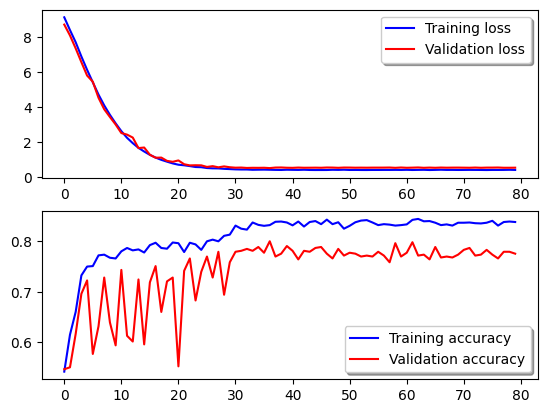

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)